### 데이터 구성 <br>
#### data_raw 폴더 아래에
- {name}_OHLCV.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 일별 데이터
- 첫 행 : Date, Close, High, Low, Open, Volume, Ticker
- 둘째 행 : , GLD, GLD, GLD, GLD, GLD

#### monthly_return 폴더 아래에
- {name}_monthly_return.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 월별 리턴 (월간 수익률) 데이터
- 첫 행 : Date, Monthly Return

#### data_monthly 폴더 아래에
- {name}_monthly.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 월별 가격 (월간 종가) 데이터
- 첫 행 : Date, Monthly Close

#### dividend_data 폴더 아래에
- {name}_dividends.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT 존재 (GLD는 없음)
- 배당 데이터
- 첫 행 : Date, Dividend

#### total_return 폴더 아래에
- {name}_total_return.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 배당 재투자 반영한 누적 수익률 데이터
- 첫 행 : Date, Monthly Return, Monthly Close, Dividend Yield, Total Return, Cumulative Return

# 1. 데이터 로딩 및 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os

# seaborn 스타일 설정
sns.set_style('whitegrid')
sns.set_context('talk')

# 종목 리스트
tickers = ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT', 'GLD']

# 폴더 경로
data_raw_path = './data_raw'
monthly_return_path = './monthly_return'
data_monthly_path = './data_monthly'
dividend_data_path = './dividend_data'
total_return_path = './total_return'

# 1) 일별 OHLCV 데이터 읽기
ohlcv_dfs = {}
for t in tickers:
    file = os.path.join(data_raw_path, f"{t}_OHLCV.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    ohlcv_dfs[t] = df

# 2) 월별 가격(종가) 데이터 읽기
monthly_close_dfs = {}
for t in tickers:
    file = os.path.join(data_monthly_path, f"{t}_monthly.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    monthly_close_dfs[t] = df

# 3) 월별 수익률 데이터 읽기
monthly_return_dfs = {}
for t in tickers:
    file = os.path.join(monthly_return_path, f"{t}_monthly_return.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    monthly_return_dfs[t] = df

# 4) 배당 데이터 (GLD 없음)
dividend_dfs = {}
for t in ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT']:
    file = os.path.join(dividend_data_path, f"{t}_dividends.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    dividend_dfs[t] = df

# 5) 배당 재투자 누적 수익률 데이터
total_return_dfs = {}
for t in tickers:
    file = os.path.join(total_return_path, f"{t}_total_return.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    total_return_dfs[t] = df

# 2. 포트폴리오 구성 및 계산

In [3]:
# 포트폴리오 가중치 (월별 수익률 기준)
portfolios = {
    'Stable': {'SPY': 0, 'SCHD': 0.28, 'QQQ': 0.12, 'TLT': 0.25, 'GLD': 0.35},
    'Aggressive': {'SPY': 0.4, 'SCHD': 0.25, 'QQQ': 0.25, 'TLT': 0.05, 'GLD': 0.05}
}

# 개별 종목 : SPY, SCHD, QQQ, TLT, GLD, JEPI
# 혼합 종목들은 가중 수익률 계산용 이름
mixed_tickers = {
    'SCHD7_QQQ3': {'SCHD':0.7, 'QQQ':0.3},
    'SCHD5_QQQ5': {'SCHD':0.5, 'QQQ':0.5},
    'SPY6_TLT4': {'SPY':0.6, 'TLT':0.4},
    'SPY9_TLT1': {'SPY':0.9, 'TLT':0.1},
    'SPY5_GLD4': {'SPY':0.5, 'GLD':0.5},
    'SPY9_GLD1': {'SPY':0.9, 'GLD':0.1}
}

In [4]:
# 모든 분석할 종목 리스트 (개별 + 혼합)
all_tickers = tickers + list(mixed_tickers.keys())

# 월별 수익률 데이터로 포트폴리오 및 혼합 종목 수익률 계산
def calc_mixed_monthly_return(weights_dict, monthly_return_dfs):
    # 날짜 기준 통합 인덱스 생성
    date_index = monthly_return_dfs['SPY'].index

    # 가중 평균 수익률 계산용 DataFrame
    df = pd.DataFrame(index=date_index)

    for name, weights in weights_dict.items():
        # 종목별 월별 수익률을 가져와서 가중평균 계산
        ret = pd.Series(0, index=date_index, dtype=float)
        for t, w in weights.items():
            ret += monthly_return_dfs[t]['Monthly Return'] * w
        df[name] = ret

    return df

# 혼합 종목 월별 수익률 계산
mixed_returns_df = calc_mixed_monthly_return(mixed_tickers, monthly_return_dfs)

# 개별 종목 월별 수익률 합치기
indiv_returns_df = pd.DataFrame({t: monthly_return_dfs[t]['Monthly Return'] for t in tickers})

# 전체 종목(개별+혼합) 월별 수익률 데이터프레임
all_returns_df = pd.concat([indiv_returns_df, mixed_returns_df], axis=1)

# 3. 그래프 그리기 : MDD (고점 대비 최대 낙폭)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 윈도우 기본 한글 폰트 경로 (맑은 고딕)
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 음수 부호가 깨질 경우 아래도 추가
plt.rcParams['axes.unicode_minus'] = False

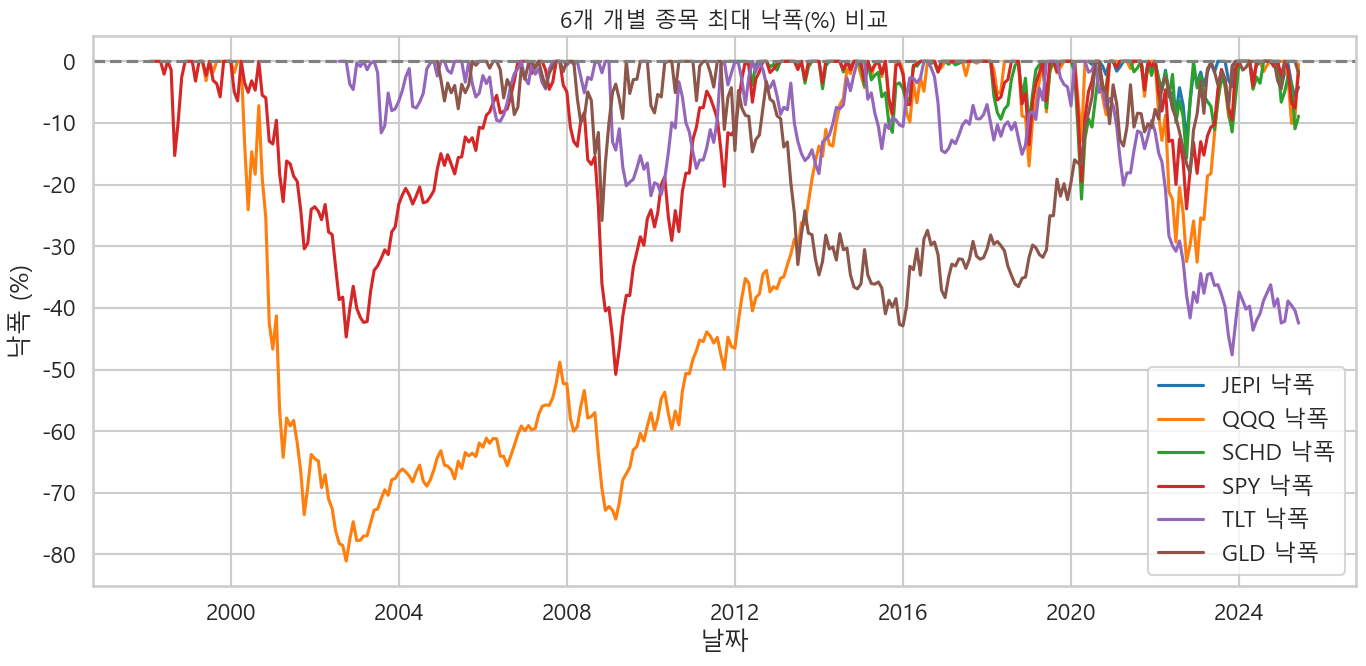

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

for ticker in tickers:
    df = monthly_close_dfs[ticker].copy()

    price_col = 'Monthly Close'  # 데이터 구조에 맞춰 변경

    df['최고가'] = df[price_col].cummax()
    df['낙폭'] = (df[price_col] - df['최고가']) / df['최고가']
    df['낙폭(%)'] = df['낙폭'] * 100

    plt.plot(df.index, df['낙폭(%)'], label=f'{ticker} 낙폭')

plt.axhline(0, color='gray', linestyle='--')
plt.title('6개 개별 종목 최대 낙폭(%) 비교', fontsize=16)
plt.xlabel('날짜')
plt.ylabel('낙폭 (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

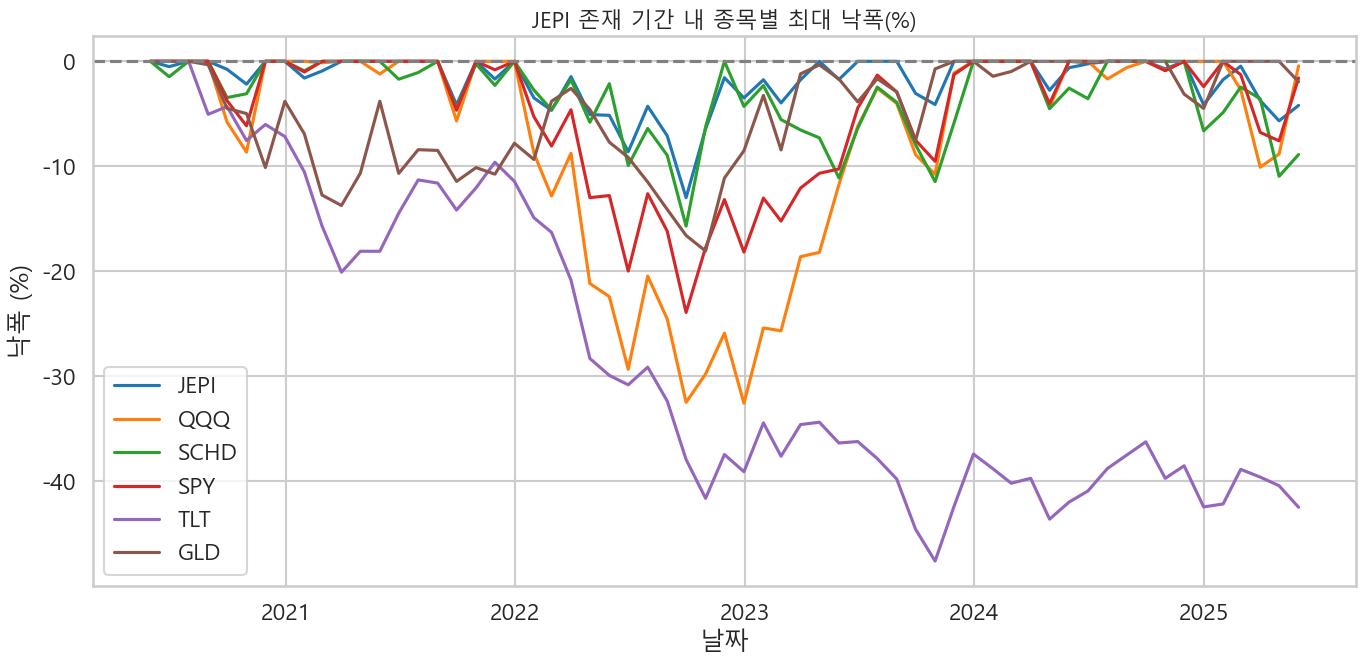

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# JEPI 데이터에서 시작일과 종료일 추출
jepi_df = monthly_close_dfs['JEPI']

# 인덱스가 날짜가 아닌 경우 처리
if not isinstance(jepi_df.index, pd.DatetimeIndex):
    if 'Date' in jepi_df.columns:
        jepi_df['Date'] = pd.to_datetime(jepi_df['Date'])
        jepi_df.set_index('Date', inplace=True)

start_date = jepi_df.index.min()
end_date = jepi_df.index.max()

# MDD 그래프
plt.figure(figsize=(14, 7))

for ticker, df in monthly_close_dfs.items():
    df = df.copy()

    # 날짜 인덱스가 아닌 경우 처리
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
        else:
            print(f"{ticker} 데이터에 'Date' 컬럼이 없습니다. 스킵합니다.")
            continue

    # JEPI 기간에 맞게 슬라이싱
    df = df.loc[(df.index >= start_date) & (df.index <= end_date)]

    # 낙폭 계산
    price_col = 'Monthly Close'
    df['최고가'] = df[price_col].cummax()
    df['낙폭'] = (df[price_col] - df['최고가']) / df['최고가']
    df['낙폭(%)'] = df['낙폭'] * 100

    plt.plot(df.index, df['낙폭(%)'], label=f'{ticker}')

plt.axhline(0, color='gray', linestyle='--')
plt.title('JEPI 존재 기간 내 종목별 최대 낙폭(%)', fontsize=16)
plt.xlabel('날짜')
plt.ylabel('낙폭 (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

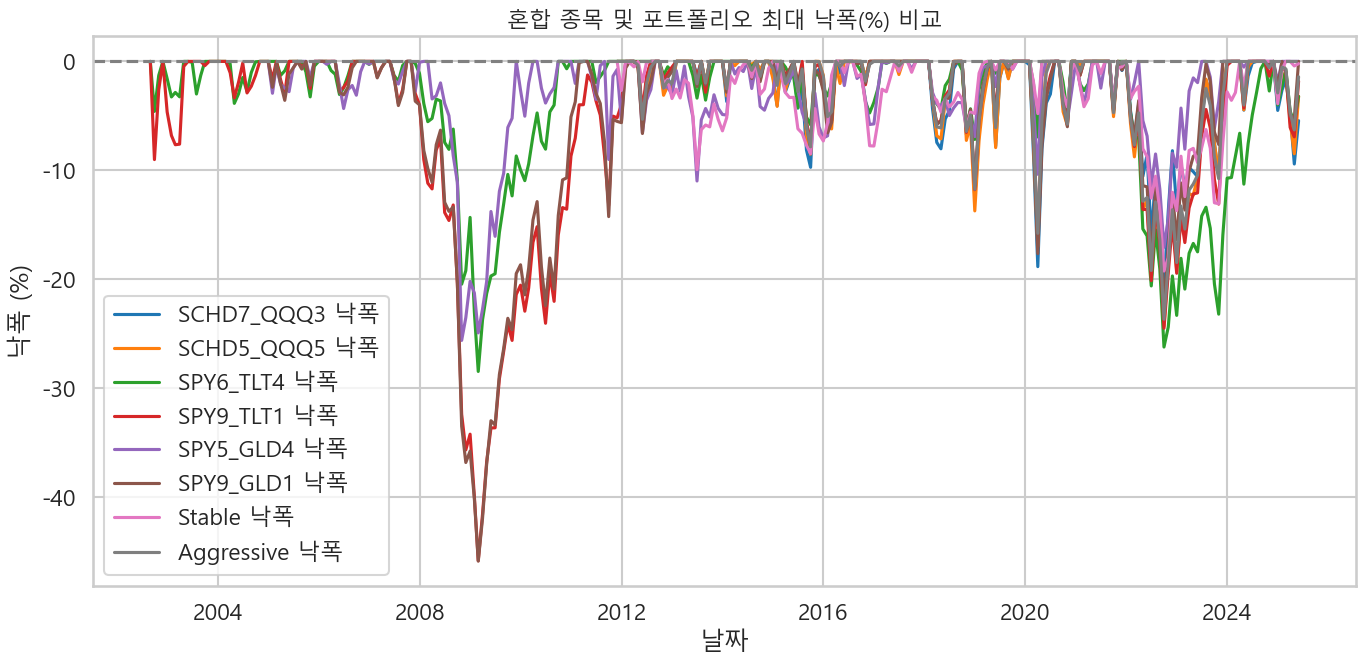

In [18]:
import matplotlib.pyplot as plt

# Stable, Aggressive 포트폴리오 수익률 계산
portfolio_returns_df = calc_mixed_monthly_return(portfolios, monthly_return_dfs)

# 전체 그릴 대상: 혼합 종목 + 포트폴리오
targets = list(mixed_tickers.keys()) + list(portfolios.keys())

plt.figure(figsize=(14, 7))

for ticker in targets:
    # 수익률 데이터 선택
    if ticker in mixed_returns_df.columns:
        returns = mixed_returns_df[ticker].copy()
    else:
        returns = portfolio_returns_df[ticker].copy()

    # 누적 수익률 계산
    cumulative = (1 + returns).cumprod()

    # 최대 낙폭 계산
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak * 100  # 낙폭(%)

    plt.plot(drawdown.index, drawdown, label=f'{ticker} 낙폭')

plt.axhline(0, color='gray', linestyle='--')
plt.title('혼합 종목 및 포트폴리오 최대 낙폭(%) 비교', fontsize=16)
plt.xlabel('날짜')
plt.ylabel('낙폭 (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

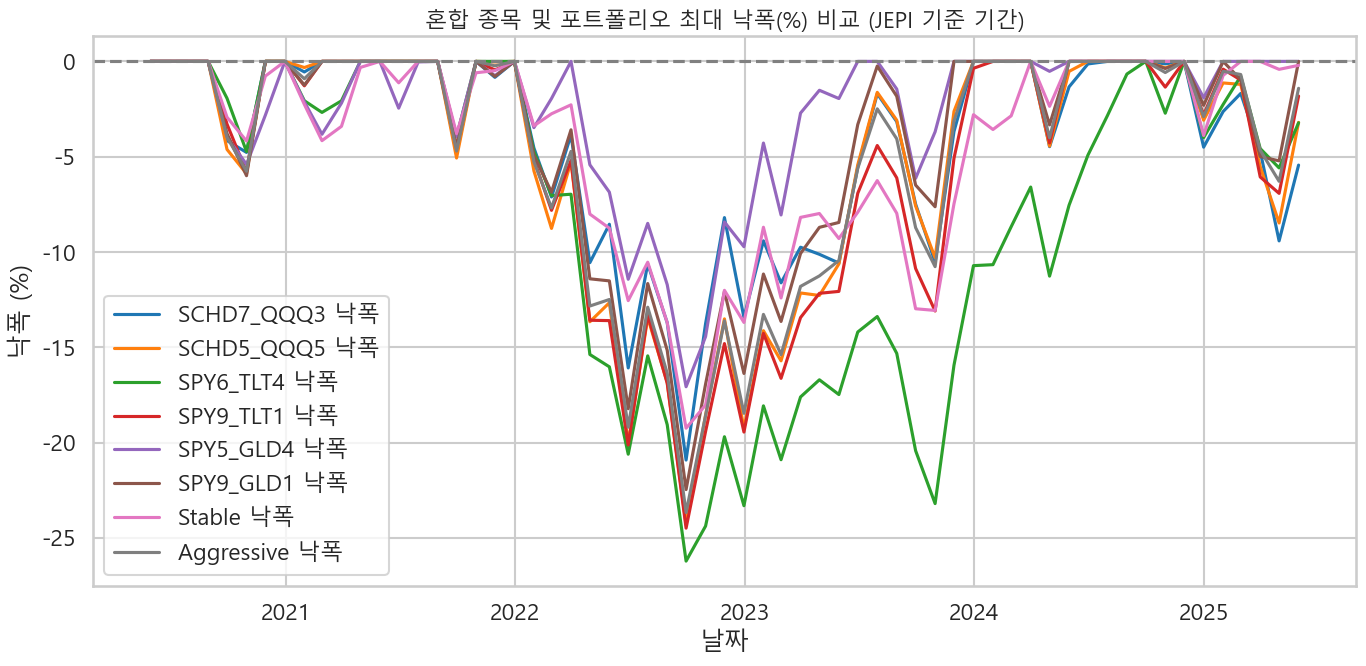

In [17]:
import matplotlib.pyplot as plt

# JEPI 기준 기간 설정
jepi_start = monthly_close_dfs['JEPI'].index.min()
jepi_end = monthly_close_dfs['JEPI'].index.max()
je_pi_period = (all_returns_df.index >= jepi_start) & (all_returns_df.index <= jepi_end)

# Stable, Aggressive 포트폴리오 수익률 계산
portfolio_returns_df = calc_mixed_monthly_return(portfolios, monthly_return_dfs)

# 전체 그릴 대상: 혼합 종목 + 포트폴리오
targets = list(mixed_tickers.keys()) + list(portfolios.keys())

plt.figure(figsize=(14, 7))

for ticker in targets:
    # 월별 누적 수익률 계산
    if ticker in mixed_returns_df.columns:
        returns = mixed_returns_df[ticker].copy()
    else:
        returns = portfolio_returns_df[ticker].copy()

    returns = returns.loc[je_pi_period]  # JEPI 기간으로 자르기
    cumulative = (1 + returns).cumprod()

    # 최대 낙폭 계산
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak * 100  # 낙폭(%)

    plt.plot(drawdown.index, drawdown, label=f'{ticker} 낙폭')

plt.axhline(0, color='gray', linestyle='--')
plt.title('혼합 종목 및 포트폴리오 최대 낙폭(%) 비교 (JEPI 기준 기간)', fontsize=16)
plt.xlabel('날짜')
plt.ylabel('낙폭 (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()